In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from torch.distributions import Dirichlet, Normal
from src import loss_functions as LF
from src import deriv_2nd_R as DR

In [2]:
def verify_m_entries(Y, sigma=0.02):
    """
    Compare manual RHS expressions for M_{(12,12)} and M_{(12,13)} 
    with values in matrix M, using mollified gradient and Hessian.
    
    Y: (n, p) tensor
    Returns: tuple (d_manual, kappa_manual)
    """
    if Y.ndim == 1:
        Y = Y.unsqueeze(0)
    n, p = Y.shape

    grad = LF.mollified_relu_grad(Y, sigma=sigma, reduction=None)  # (n, p)
    hess = LF.mollified_relu_hess(Y, sigma=sigma, reduction=None)  # (n, p, p)

    y1, y2, y3 = Y[:, 0], Y[:, 1], Y[:, 2]
    g1, g2 = grad[:, 0], grad[:, 1]
    h11 = hess[:, 0, 0]
    h12 = hess[:, 0, 1]
    h21 = hess[:, 1, 0]
    h22 = hess[:, 1, 1]

    ### RHS for M_{(12,12)}:
    term_d = y1 * (y1 * h22 - y2 * h12 - g1)  # shape (n,)
    d_manual = term_d.mean()

    ### RHS for M_{(12,13)}:
    term_kappa = y3 * (y2 * h11 + (y3 - 2 * y1) * h21 - g2)  # shape (n,)
    kappa_manual = 0.5 * term_kappa.mean()

    return [d_manual.item(), kappa_manual.item()]


In [3]:
p = 10

alpha = torch.ones(p, p, dtype= torch.float32) + torch.eye(p, dtype= torch.float32)*2
# alpha = torch.tensor([[10, 1, 1, 1], [1, 10, 1], [1, 1, 10]], dtype= torch.float64)
# alpha = torch.tensor([[5, 1]], dtype= torch.float64)
n= 30000
K, p = alpha.shape
# torch.manual_seed(5)
dir = Dirichlet(alpha)
X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p)[:, :(p-1)].to("cuda")

**We first look at the our Mollified ReLU-Simplex Loss. It is known to be PD for the given data.**

Currently at 100.00%      

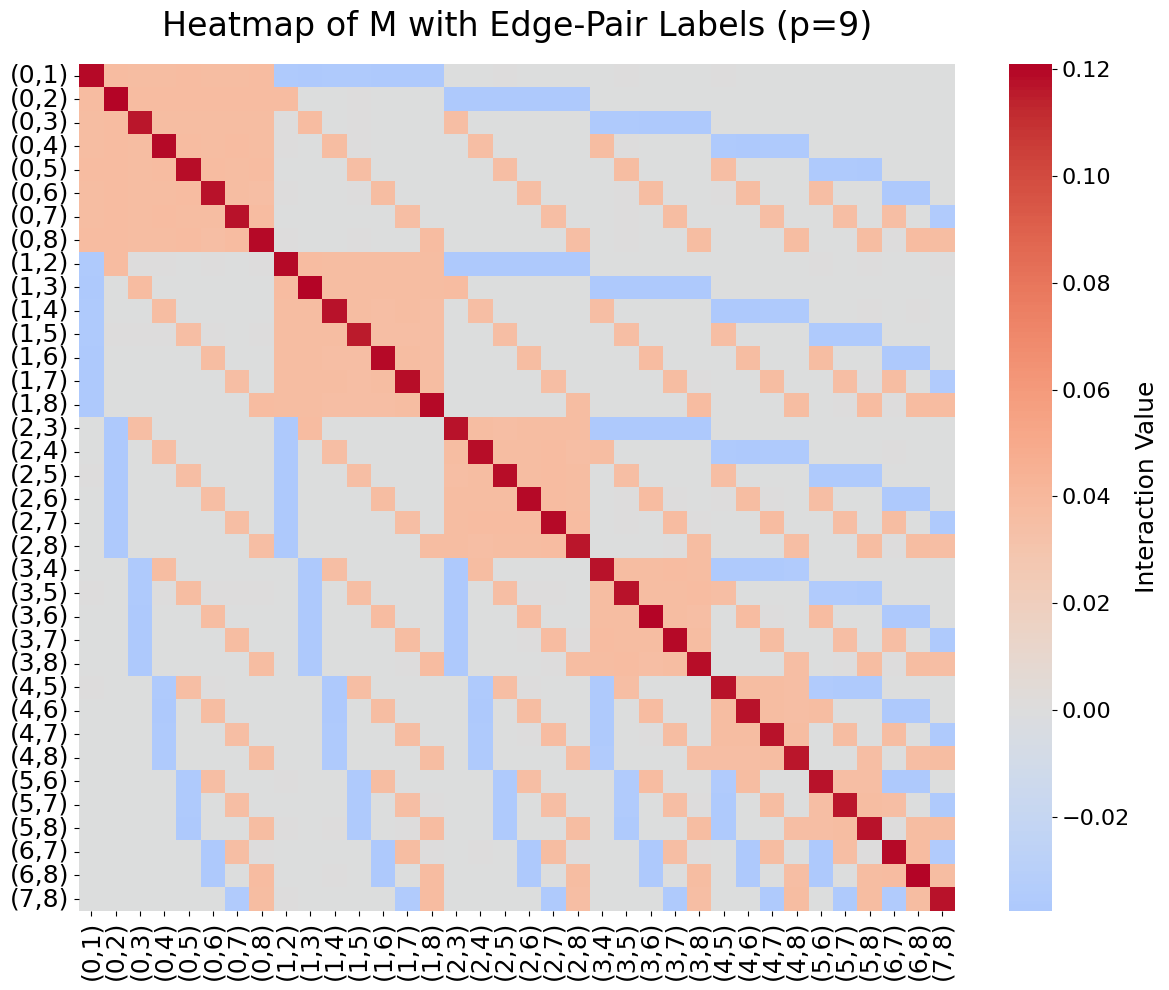

In [4]:
M = DR.construct_M_from_basis(LF.mollified_relu_simplex_core, X, 0.02, LF.mollified_relu_grad, LF.mollified_relu_hess)
# print(torch.tensor(verify_m_entries(X), device = "cuda")- M[1,1:3].to("cuda"))
DR.plot_M_heatmap(M, True)

**We then look at the Quadratic-Sum-Penalty Loss. It is known to be ND with certain parameters for the given data.**

Currently at 100.00%      

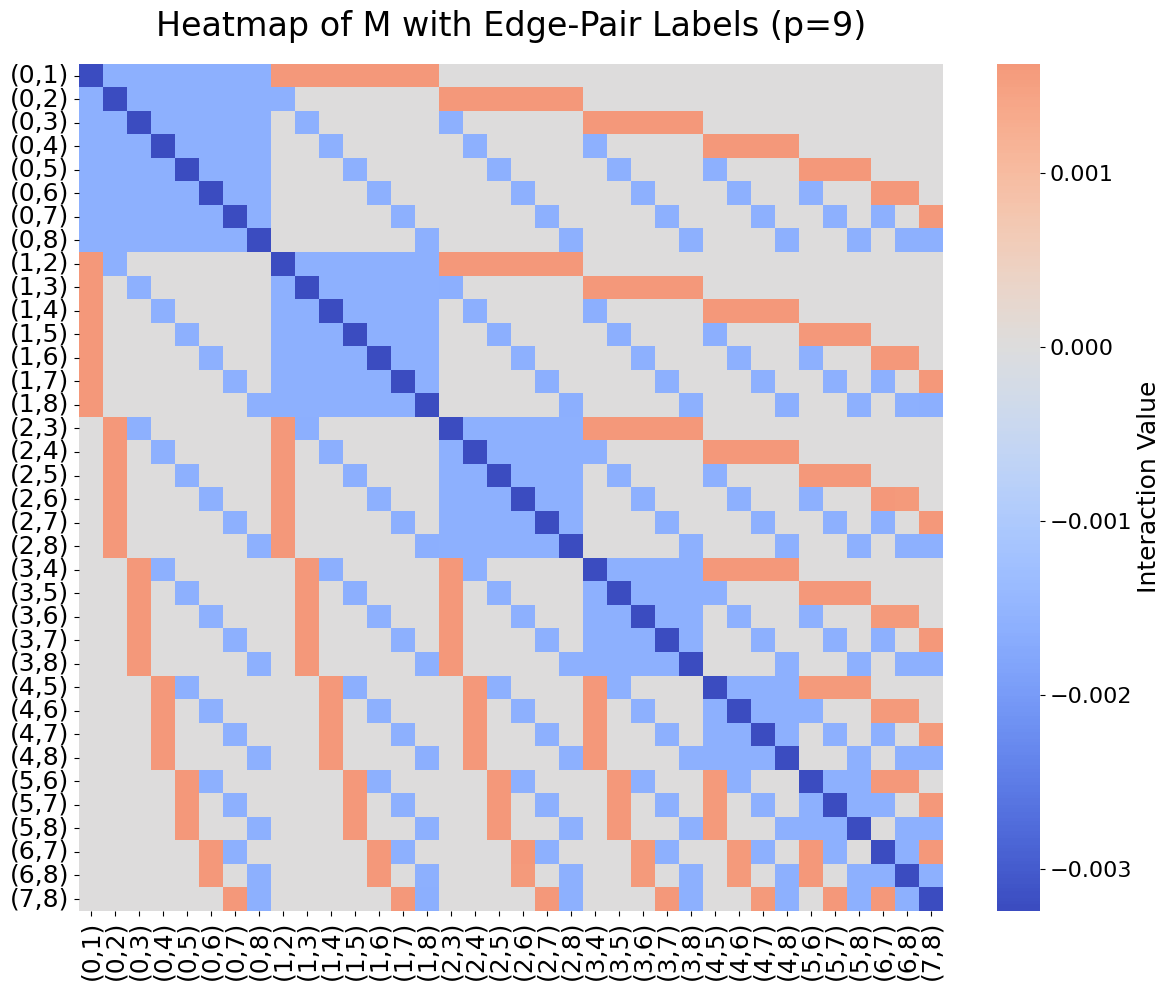

In [5]:
M_quad = DR.construct_M_from_basis(LF.quadratic_sum_penalty_core, X, -0.02)
DR.plot_M_heatmap(M_quad)

**Below we try to verify that the decomposition $\text{skew}(p) = \mathcal{U} \oplus \mathcal{U}^\perp$, and see if Schur's Lemma is applicable.**
1. We see from the block diagonalization that the eigenvalues of $M$ divides into $2$ groups. $\implies$ Schur's Lemma is applausible.
2. We hypothesize that $\mathcal{U}$, the standard representation of $S_p$, corresponds to one eigenspace of $M$. To test this, we construct a matrix $U$ spanning $\mathcal{U}$, project the eigenvectors of $M$ onto $\mathcal{U}^\perp$, and assess their alignment. $\implies$ Schur's Lemma seems to be right.

In [6]:
def block_diagonalize(M, num_top=None):
    """
    Diagonalize or block-structure a symmetric matrix M via eigendecomposition.

    Parameters:
        M (Tensor): Symmetric matrix (n x n)
        num_top (int): Optional. If provided, sorts eigenvectors so top `num_top` largest
                       eigenvalues come last (block-structured view)

    Returns:
        M_block (Tensor): Matrix in the eigenbasis
        Q (Tensor): Eigenvector matrix (columns are eigenvectors)
        eigvals (Tensor): Eigenvalues (in sorted order)
    """
    eigvals, Q = torch.linalg.eigh(M)
    
    if num_top is not None:
        # Reorder eigenvalues and eigenvectors to group top modes
        idx = torch.argsort(eigvals)  # ascending
        # move top `num_top` to the end
        if num_top > 0:
            idx = torch.cat([idx[:-num_top], idx[-num_top:]], dim=0)
        eigvals = eigvals[idx]
        Q = Q[:, idx]

    M_block = Q.T @ M @ Q  # should be diagonal or nearly block diagonal
    return M_block, Q, eigvals


def construct_node_flow_matrix(p):
    """
    Constructs the matrix U ∈ R^{binom(p,2) × p}, where each column u_i represents
    the node-based skew flow centered at node i in the B(i,j) basis.
    """
    edge_list = list(combinations(range(p), 2))  # ordered pairs (i < j)
    edge_to_index = {e: k for k, e in enumerate(edge_list)}  # map (i,j) to row index

    num_edges = len(edge_list)
    U = torch.zeros((num_edges, p))  # each column is a u_i

    for i in range(p):
        for j in range(p):
            if i == j:
                continue
            # Make sure we use (min, max) since B(i,j) = -B(j,i)
            e = tuple(sorted((i, j)))
            sign = 1 if i < j else -1  # account for antisymmetry
            row_idx = edge_to_index[e]
            U[row_idx, i] += sign

    return U, edge_list


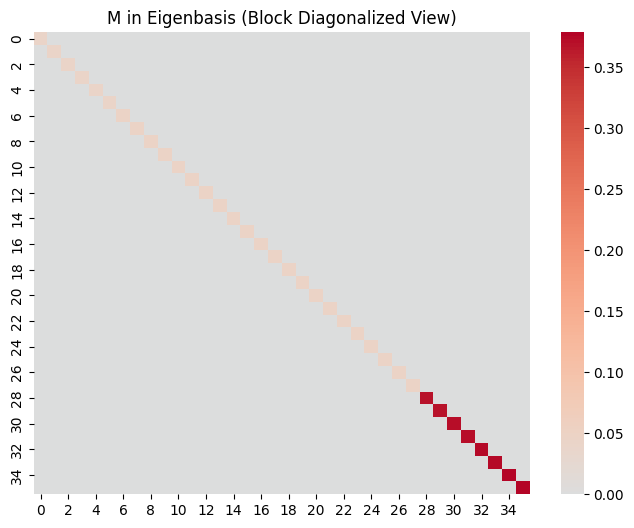

Residuals of Q_top outside skew-flow space: tensor([0.9651, 0.9990, 0.9376, 0.9979, 0.9265, 0.9914, 0.9809, 0.9998, 0.9982,
        0.9984, 0.9995, 0.9957, 0.9819, 0.9927, 0.9920, 0.9999, 0.9860, 0.9889,
        0.9577, 0.9284, 0.9914, 0.9560, 0.9908, 0.9999, 1.0000, 0.9806, 0.9571,
        0.9954, 0.0035, 0.0055, 0.0043, 0.0052, 0.0045, 0.0045, 0.0067, 0.0056],
       device='cuda:0')


In [7]:
M_block, Q, eigvals = block_diagonalize(M, num_top=p)  # p = the number of large-eigenvalue modes

plt.figure(figsize=(8, 6))
sns.heatmap(M_block.cpu().numpy(), cmap='coolwarm', center=0)
plt.title("M in Eigenbasis (Block Diagonalized View)")
plt.show()


U = construct_node_flow_matrix(p-1)[0]
P_orth, _ = torch.linalg.qr(U)  # Q ∈ R^{binom(p,2) × p}, orthonormal columns
P = (P_orth @ P_orth.T).to("cuda")  # projection onto the column space of Q = U
# Q_top = Q[:, -(p-2):]  # shape: [dim, num_top]
Q_top = Q
residuals = torch.norm((torch.eye(P.shape[0], device=P.device) - P) @ Q_top, dim=0)
print("Residuals of Q_top outside skew-flow space:", residuals)